In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import matplotlib.dates as mdates
import plotly.graph_objects as go

In [60]:
# Name the columns of the dataframe
geosun_col = ['TIME','DHI','GHI1','GHI2','airtemp','rel_hum','bar_p','precipitation','wind_speed','wind_dir','GTI_cleam','GTI_dirt','GTI_month','sensor_cleaning','comment']
geosun_use = list(np.arange(len(geosun_col)))

#Call the weather data: 'narok' or 'homa-bay' for 'year1' or 'year2' (corresponding to 2020 or 2021)
df = pd.read_csv(os.path.join(os.getcwd(), 'HomaBay_Narok_data_2020_2021', 'solar-measurements_kenya-narok_world-bank_year2_qc.csv'),header=None,skiprows=1,names=geosun_col,na_filter=True,
                   na_values=-200,usecols=geosun_use)

#Change the timestamp to datetime format
df['TIME'] = pd.to_datetime(df['TIME'],format='%d/%m/%Y %H:%M')

# Forward fill missing values in the 'GHI' and 'airtemp' column
df['GHI1'] = df['GHI1'].ffill()
df['GHI2'] = df['GHI2'].ffill()
df['airtemp'] = df['airtemp'].ffill()

# Set 'timestamp' as the index
df.set_index('TIME', inplace=True)


/var/folders/yg/cg9wv8tx2mv56kw5vh03hsnm0000gn/T/ipykernel_15063/2865937774.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(os.getcwd(), 'HomaBay_Narok_data_2020_2021', 'solar-measurements_kenya-narok_world-bank_year2_qc.csv'),header=None,skiprows=1,names=geosun_col,na_filter=True,


the number of times the pasteurisation temperature is reached is:
31
the average daily volume of pasteurised effluent is:
154.99999999999997
the average daily volume of pasteurised effluent per m2 is:
98.97828863346102
the median holding time of pasteurised effluent is:
24.0
the minimum holding time of pasteurised effluent is:
20


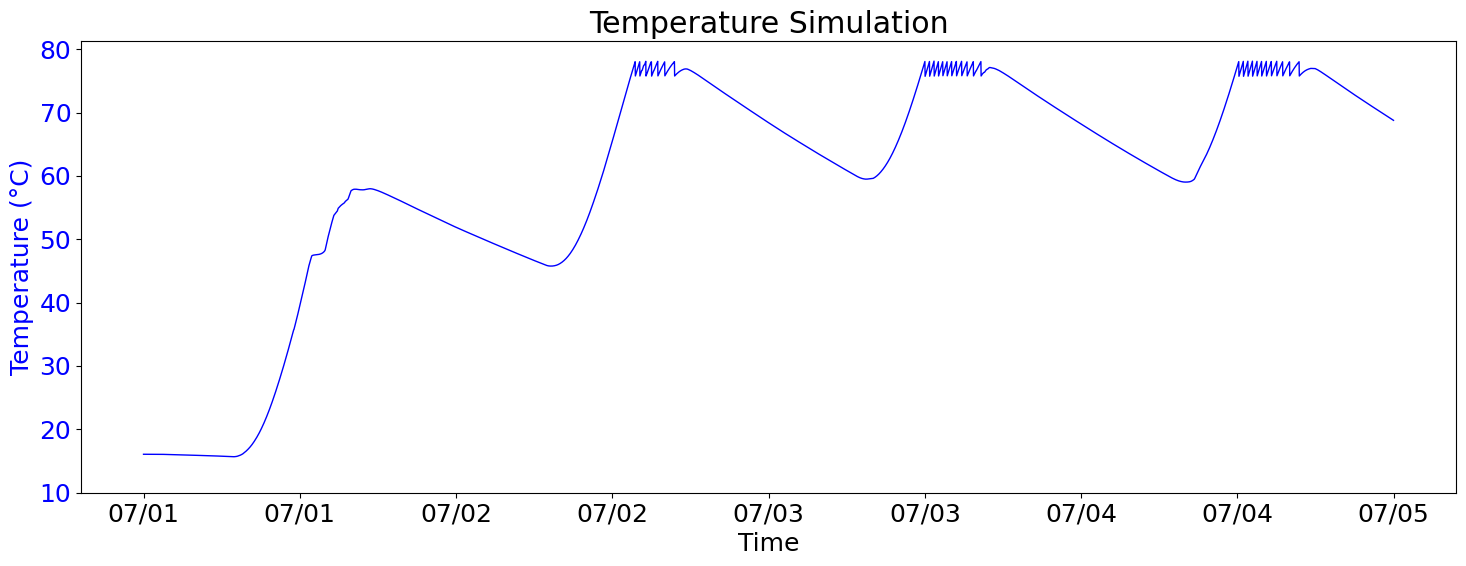

In [62]:
#TEMPERATURE SIMULATION ON CHOSEN TIMEFRAME

#Define a timeframe for the simulation
start_date = '2021-07-01'
end_date = '2021-07-04'

#Calculating the length of the simulation
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
difference = end_date_dt - start_date_dt
days_difference = difference.days

# Slicing the dataframe to the chosen timeframe
df_sliced = df.loc[start_date:end_date]

# Initializing MT_sim (Main Tank simulation temperature)
MT_sim = pd.Series([0.0] * len(df_sliced['GHI1']), index=df_sliced.index, dtype='float64')

#Optimised parameters U and k, obtained by best fit using gridsearch in Model_Building notebook
U = 2.413793103448276 #overall heat transfer coefficient
k = 0.993103448275862 #radiation heat gain factor

#Control Parameters
T_flow = 78 #Thermostat valve temperature setpoint. Temperature at which the sludge will flow out of the system
T_past = 72 #Pasteurisation temperature. Is used to calculate the holding time
e=0.6 #Heat exchanger efficiency
x=0.9 #Discharge factor x. Portion of main tank that does NOT flow out when T_flow is reached
Main_tank_cap= 150 #Main tank capacity


A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100) #This is the heat exchange area of the cylindrical main tank. See annex 2 of the report
T_flow_reached = 0 # Initialised batch count
Holding_time = [0] # Initialised holding time
MT_sim.iloc[0] = df_sliced['airtemp'].iloc[0]  # Initialise main tank temperature at ambient air temp

for i in range(len(df_sliced['GHI1']) - 1):
    if MT_sim.iloc[i] > T_past:
        Holding_time[T_flow_reached] +=1 # For every minute that a batch spends above T_past, holding time is increased
    if MT_sim.iloc[i] < T_flow: # As long as T_flow is not reached, system behaves like a normal solar water heater with temperature gain and loss
        MT_sim.iloc[i + 1] = (MT_sim.iloc[i] +
                              k * df_sliced['GHI1'].iloc[i] * (0.1044*Main_tank_cap/10) * 60 / (4184 * Main_tank_cap) -
                              U * A * (MT_sim.iloc[i] - df_sliced['airtemp'].iloc[i]) * 60 / (4184 * Main_tank_cap))
    else: # When T_flow is reached, system discharges sludge, and temperature resets lower, according to the heatX efficiency and discharge factor x
        T_preheated= df_sliced['airtemp'].iloc[i] + e*(T_flow-df_sliced['airtemp'].iloc[i]) # temperature of incoming fresh sludge after preheating in the heat exchanger
        MT_sim.iloc[i + 1] = x*T_flow + (1-x)*T_preheated # Main tank temperature reset with mix of preheated sludge and hot (but not discharged) sludge
        T_flow_reached +=1 # Batch count increases by 1
        Holding_time.append(0) # Holding time for the batch is recorded

Average_Processed_Vol = (T_flow_reached*(1-x)*Main_tank_cap)/days_difference # Number of batches * volume per batch / number of days = average daily processed volume
Average_Processed_Vol_perm2 = (T_flow_reached*(1-x)*Main_tank_cap)/days_difference/(0.1044*Main_tank_cap/10) # average daily processed volume / solar collector area (calculated according to the SevenStarsSolar catalog
Holding_time.pop() # get rid of last null value
Average_Holding_time = np.mean(Holding_time) # Average holding time (is not representative as some holding times are very long and stretch out the mean)
Median_Holding_time = np.median(Holding_time) # Median holding time is more representative
Min_Holding_time = min(Holding_time) # Worst case value: minimum holding time

# Create a figure and axis
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot MT_sim with the datetime index on the x-axis
ax1.plot(MT_sim.index, MT_sim, label='Temperature Simulation', color='b', linewidth=1)
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (°C)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) #format dates in x-axis

# Set the y-axis limits to ensure the minimum is 20 degrees
ax1.set_ylim(10, ax1.get_ylim()[1])

# Add a title and a legend
plt.title('Temperature Simulation')
fig.tight_layout()
#plt.savefig('/Users/tim-luan/Documents/Master Thesis/figures/HomaBay_optimised_params')

print('the number of times the pasteurisation temperature is reached is:')
print(T_flow_reached)

print('the average daily volume of pasteurised effluent is:')
print(Average_Processed_Vol)

print('the average daily volume of pasteurised effluent per m2 is:')
print(Average_Processed_Vol_perm2)

print('the median holding time of pasteurised effluent is:')
print(Median_Holding_time)

print('the minimum holding time of pasteurised effluent is:')
print(Min_Holding_time)

In [20]:
# MAPPING FLOW TEMPERATURE UNDER COLD CONDITIONS

start_date = '2021-07-01'
end_date = '2021-08-01'

start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
difference = end_date_dt - start_date_dt
days_difference = difference.days

df_sliced = df.loc[start_date:end_date]

MT_sim = pd.Series([0.0] * len(df_sliced['GHI1']), index=df_sliced.index, dtype='float64')

#Standard values with T_flow analysis
U = 2.413793103448276
k = 0.993103448275862
T_flow_values = np.linspace(70, 82, 41) #Varying the temperature setpoint of the thermostat valve to see its effect
e=0.6
x=0.5 
Main_tank_cap=150
A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100)

Processed_Vol_T_flow = []
Median_Holding_Time_T_flow = []

for T_flow in T_flow_values:
    T_flow_reached = 0
    Holding_time = [0]
    Median_Holding_Time = 0
    MT_sim.iloc[0] = df_sliced['airtemp'].iloc[0] 
    for i in range(len(df_sliced['GHI1']) - 1):
        if MT_sim.iloc[i] > T_past:
            Holding_time[T_flow_reached] +=1
        if MT_sim.iloc[i] < T_flow:
            MT_sim.iloc[i + 1] = (MT_sim.iloc[i] +
                              k * df_sliced['GHI1'].iloc[i] * (0.1044*Main_tank_cap/10) * 60 / (4184 * Main_tank_cap) -
                              U * A * (MT_sim.iloc[i] - df_sliced['airtemp'].iloc[i]) * 60 / (4184 * Main_tank_cap))
        else:
            T_preheated= df_sliced['airtemp'].iloc[i] + e*(T_flow-df_sliced['airtemp'].iloc[i])
            MT_sim.iloc[i + 1] = x*T_flow + (1-x)*T_preheated
            T_flow_reached +=1
            Holding_time.append(0)
            
    Average_Processed_Vol = (T_flow_reached*(1-x)*Main_tank_cap)/days_difference/(0.1044*Main_tank_cap/10)
    Processed_Vol_T_flow.append(Average_Processed_Vol)
    Holding_time.pop()
    Median_Holding_time = np.median(Holding_time)
    Median_Holding_Time_T_flow.append(Median_Holding_time)
    

In [21]:
# MAPPING FLOW TEMPERATURE UNDER HOT CONDITIONS

start_date = '2021-03-01'
end_date = '2021-04-01'

start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
difference = end_date_dt - start_date_dt
days_difference = difference.days

df_sliced = df.loc[start_date:end_date]

MT_sim = pd.Series([0.0] * len(df_sliced['GHI1']), index=df_sliced.index, dtype='float64')

#Standard values with T_flow analysis
U = 2.413793103448276
k = 0.993103448275862
T_flow_values_2 = np.linspace(70, 82, 41) #Varying the temperature setpoint of the thermostat valve to see its effect
e=0.6
x=0.5
Main_tank_cap=150
A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100)

Processed_Vol_T_flow_2 = []
Median_Holding_Time_T_flow_2 = []

for T_flow in T_flow_values_2:
    T_flow_reached = 0
    Holding_time = [0]
    Median_Holding_Time = 0
    MT_sim.iloc[0] = df_sliced['airtemp'].iloc[0]
    for i in range(len(df_sliced['GHI1']) - 1):
        if MT_sim.iloc[i] > T_past:
            Holding_time[T_flow_reached] +=1
        if MT_sim.iloc[i] < T_flow:
            MT_sim.iloc[i + 1] = (MT_sim.iloc[i] +
                              k * df_sliced['GHI1'].iloc[i] * (0.1044*Main_tank_cap/10) * 60 / (4184 * Main_tank_cap) -
                              U * A * (MT_sim.iloc[i] - df_sliced['airtemp'].iloc[i]) * 60 / (4184 * Main_tank_cap))
        else:
            T_preheated= df_sliced['airtemp'].iloc[i] + e*(T_flow-df_sliced['airtemp'].iloc[i])
            MT_sim.iloc[i + 1] = x*T_flow + (1-x)*T_preheated
            T_flow_reached +=1
            Holding_time.append(0)
            
    Average_Processed_Vol = (T_flow_reached*(1-x)*Main_tank_cap)/days_difference/(0.1044*Main_tank_cap/10)
    Processed_Vol_T_flow_2.append(Average_Processed_Vol)
    Holding_time.pop()
    Median_Holding_time = np.median(Holding_time)
    Median_Holding_Time_T_flow_2.append(Median_Holding_time)


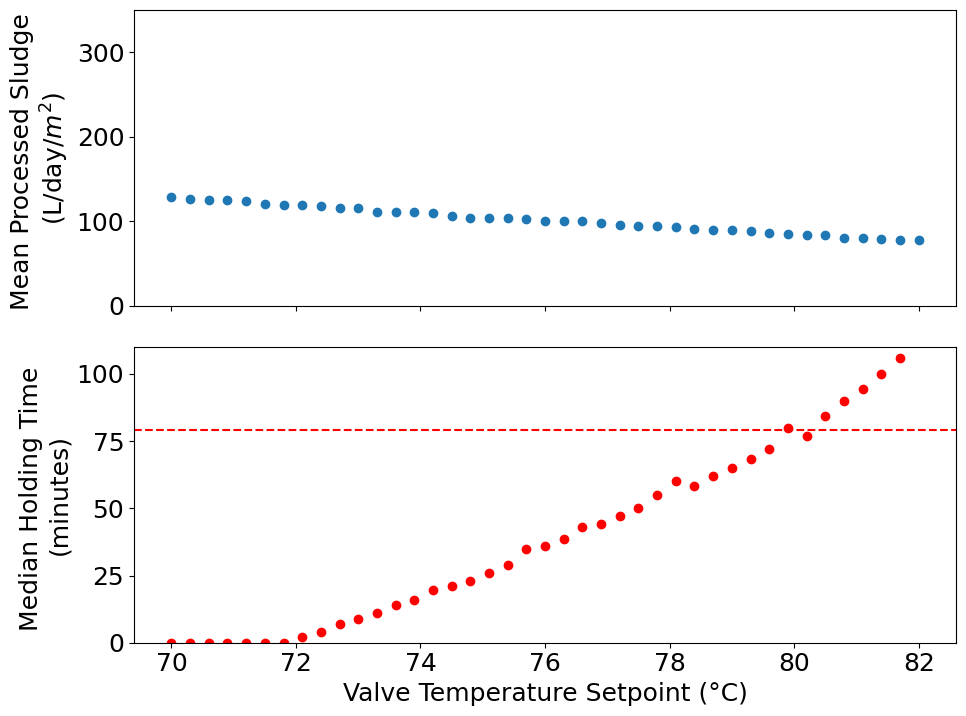

In [44]:
# Plotting processed volume under cold conditions and holding time under hot conditions

plt.rcParams.update({'font.size': 18})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7.5), sharex=True)

# First subplot: Scatter plot of Processed Vol vs T Flow
ax1.scatter(T_flow_values, Processed_Vol_T_flow)
ax1.set_ylim(0, 350)  # Set y-axis limits
ax1.set_ylabel('Mean Processed Sludge \n(L/day/$m^2$)', fontsize=18)
#ax1.set_title('Effect on Processed Volume')

# Second subplot: Scatter plot of Holding Time vs T Flow
ax2.scatter(T_flow_values, Median_Holding_Time_T_flow_2, color='red')
ax2.set_ylim(0, 110)  # Set y-axis limits
ax2.set_ylabel('Median Holding Time \n(minutes)', fontsize=18)
#ax2.set_title('Effect on Holding Time')
ax2.axhline(y=79, color='red', linestyle='--') # Add horizontal line at y=79 (necessary holding time for 90% reduction at 72 °C)

# Set the x-axis label for the second subplot (shared x-axis)
ax2.set_xlabel('Valve Temperature Setpoint (°C)')

# Adjust the layout to prevent overlapping labels
plt.tight_layout()
#plt.savefig('/Users/tim-luan/Documents/Master Thesis/figures/Param_Flow_temp')

In [23]:
# MAPPING HEATX EFFICIENCY UNDER COLD CONDITIONS

start_date = '2021-07-01'
end_date = '2021-08-01'

start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
difference = end_date_dt - start_date_dt
days_difference = difference.days

df_sliced = df.loc[start_date:end_date]

MT_sim = pd.Series([0.0] * len(df_sliced['GHI1']), index=df_sliced.index, dtype='float64')

#Standard values with HeatX Efficiency analysis
U = 2.413793103448276
k = 0.993103448275862
T_flow = 78
e_values = np.linspace(0.3, 0.9, 31) #Varying the Heat Exchanger Efficiency to see its effect
x=0.5
Main_tank_cap=150
A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100)

Processed_Vol_e = []
Median_Holding_Time_e = []

for e in e_values:
    T_flow_reached = 0
    Holding_time = [0]
    Median_Holding_Time = 0
    MT_sim.iloc[0] = df_sliced['airtemp'].iloc[0]
    for i in range(len(df_sliced['GHI1']) - 1):
        if MT_sim.iloc[i] > T_past:
            Holding_time[T_flow_reached] +=1
        if MT_sim.iloc[i] < T_flow:
            MT_sim.iloc[i + 1] = (MT_sim.iloc[i] +
                              k * df_sliced['GHI1'].iloc[i] * (0.1044*Main_tank_cap/10) * 60 / (4184 * Main_tank_cap) -
                              U * A * (MT_sim.iloc[i] - df_sliced['airtemp'].iloc[i]) * 60 / (4184 * Main_tank_cap))
        else:
            T_preheated= df_sliced['airtemp'].iloc[i] + e*(T_flow-df_sliced['airtemp'].iloc[i])
            MT_sim.iloc[i + 1] = x*T_flow + (1-x)*T_preheated
            T_flow_reached +=1
            Holding_time.append(0)
            
    Average_Processed_Vol = (T_flow_reached*(1-x)*Main_tank_cap)/days_difference/(0.1044*Main_tank_cap/10)
    Processed_Vol_e.append(Average_Processed_Vol)
    Holding_time.pop()
    Median_Holding_time = np.median(Holding_time)
    Median_Holding_Time_e.append(Median_Holding_time)


In [24]:
# MAPPING HEATX EFFICIENCY UNDER HOT CONDITIONS

start_date = '2021-03-01'
end_date = '2021-04-01'

start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
difference = end_date_dt - start_date_dt
days_difference = difference.days

df_sliced = df.loc[start_date:end_date]

MT_sim = pd.Series([0.0] * len(df_sliced['GHI1']), index=df_sliced.index, dtype='float64')

#Standard values with HeatX Efficiency analysis
U = 2.413793103448276
k = 0.993103448275862
T_flow = 78
e_values = np.linspace(0.3, 0.9, 31)  #Varying the Heat Exchanger Efficiency to see its effect
x=0.5
Main_tank_cap=150
A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100)

Processed_Vol_e_2 = []
Median_Holding_Time_e_2 = []

for e in e_values:
    T_flow_reached = 0 
    Holding_time = [0]
    Median_Holding_Time = 0
    MT_sim.iloc[0] = df_sliced['airtemp'].iloc[0]
    for i in range(len(df_sliced['GHI1']) - 1):
        if MT_sim.iloc[i] > T_past:
            Holding_time[T_flow_reached] +=1
        if MT_sim.iloc[i] < T_flow:
            MT_sim.iloc[i + 1] = (MT_sim.iloc[i] +
                              k * df_sliced['GHI1'].iloc[i] * (0.1044*Main_tank_cap/10) * 60 / (4184 * Main_tank_cap) -
                              U * A * (MT_sim.iloc[i] - df_sliced['airtemp'].iloc[i]) * 60 / (4184 * Main_tank_cap))
        else:
            T_preheated= df_sliced['airtemp'].iloc[i] + e*(T_flow-df_sliced['airtemp'].iloc[i])
            MT_sim.iloc[i + 1] = x*T_flow + (1-x)*T_preheated
            T_flow_reached +=1
            Holding_time.append(0)
            
    Average_Processed_Vol = (T_flow_reached*(1-x)*Main_tank_cap)/days_difference/(0.1044*Main_tank_cap/10)
    Processed_Vol_e_2.append(Average_Processed_Vol)
    Holding_time.pop()
    Median_Holding_time = np.median(Holding_time)
    Median_Holding_Time_e_2.append(Median_Holding_time)

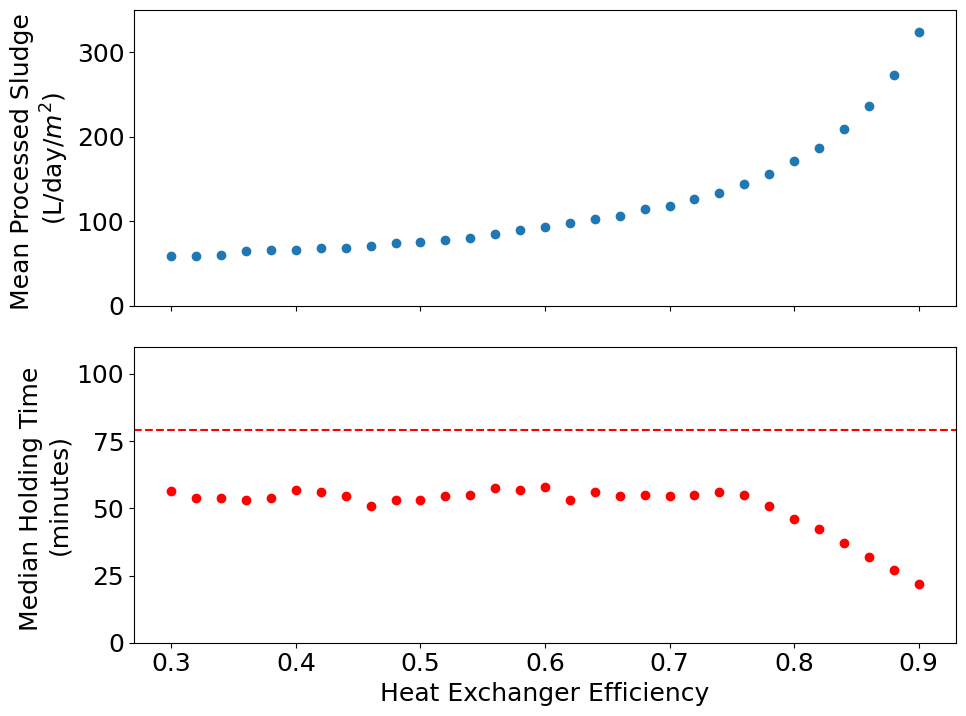

In [46]:
# Plotting processed volume under cold conditions and holding time under hot conditions

plt.rcParams.update({'font.size': 18})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7.5), sharex=True)

# First subplot: Scatter plot of Processed Vol vs Heat Exchanger efficiency
ax1.scatter(e_values, Processed_Vol_e)
ax1.set_ylim(0, 350)  # Set y-axis limits
ax1.set_ylabel('Mean Processed Sludge \n(L/day/$m^2$)', fontsize=18)
#ax1.set_title('Effect on Processed Volume')

# Second subplot: Scatter plot of Holding Time vs Heat Exchanger efficiency
ax2.scatter(e_values, Median_Holding_Time_e_2, color='red')
ax2.set_ylim(0, 110)  # Set y-axis limits
ax2.set_ylabel('Median Holding Time \n(minutes)', fontsize=18)
#ax2.set_title('Effect on Holding Time')
ax2.axhline(y=79, color='red', linestyle='--') # Add horizontal line at y=79 (necessary holding time for 90% reduction at 72 °C)

# Set the x-axis label for the second subplot (shared x-axis)
ax2.set_xlabel('Heat Exchanger Efficiency')

# Adjust the layout to prevent overlapping labels
plt.tight_layout()
#plt.savefig('/Users/tim-luan/Documents/Master Thesis/figures/Param_HXE')

In [26]:
# MAPPING DISCHARGE FACTOR UNDER COLD CONDITIONS

start_date = '2021-07-01'
end_date = '2021-08-01'

start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
difference = end_date_dt - start_date_dt
days_difference = difference.days

df_sliced = df.loc[start_date:end_date]

MT_sim = pd.Series([0.0] * len(df_sliced['GHI1']), index=df_sliced.index, dtype='float64')

#Standard values with Discharge Factor analysis
U = 2.413793103448276
k = 0.993103448275862
T_flow = 78
e = 0.6
x_values = np.linspace(0.2, 0.99, 50) #Varying the Discharge Factor x to see its effect
Main_tank_cap= 150
A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100)

Processed_Vol_x = []
Median_Holding_Time_x = []

for x in x_values:
    T_flow_reached = 0
    Holding_time = [0]
    Median_Holding_Time = 0
    MT_sim.iloc[0] = df_sliced['airtemp'].iloc[0]
    for i in range(len(df_sliced['GHI1']) - 1):
        if MT_sim.iloc[i] > T_past:
            Holding_time[T_flow_reached] +=1
        if MT_sim.iloc[i] < T_flow:
            MT_sim.iloc[i + 1] = (MT_sim.iloc[i] +
                              k * df_sliced['GHI1'].iloc[i] * (0.1044*Main_tank_cap/10) * 60 / (4184 * Main_tank_cap) -
                              U * A * (MT_sim.iloc[i] - df_sliced['airtemp'].iloc[i]) * 60 / (4184 * Main_tank_cap))
        else:
            T_preheated= df_sliced['airtemp'].iloc[i] + e*(T_flow-df_sliced['airtemp'].iloc[i])
            MT_sim.iloc[i + 1] = x*T_flow + (1-x)*T_preheated
            T_flow_reached +=1
            Holding_time.append(0)
            
    Average_Processed_Vol = (T_flow_reached*(1-x)*Main_tank_cap)/days_difference/(0.1044*Main_tank_cap/10)
    Processed_Vol_x.append(Average_Processed_Vol)
    Holding_time.pop()
    Median_Holding_time = np.median(Holding_time)
    Median_Holding_Time_x.append(Median_Holding_time)


In [27]:
# MAPPING DISCHARGE FACTOR UNDER HOT CONDITIONS

start_date = '2021-03-01'
end_date = '2021-04-01'

start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
difference = end_date_dt - start_date_dt
days_difference = difference.days

df_sliced = df.loc[start_date:end_date]

MT_sim = pd.Series([0.0] * len(df_sliced['GHI1']), index=df_sliced.index, dtype='float64')

#Standard values with Discharge Factor analysis
U = 2.413793103448276
k = 0.993103448275862
T_flow = 78
e = 0.6
x_values = np.linspace(0.2, 0.99, 50) #Varying the Discharge Factor x to see its effect
Main_tank_cap=150
A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100)

Processed_Vol_x_2 = []
Median_Holding_Time_x_2 = []

for x in x_values:
    T_flow_reached = 0
    Holding_time = [0]
    Median_Holding_Time = 0
    MT_sim.iloc[0] = df_sliced['airtemp'].iloc[0]
    for i in range(len(df_sliced['GHI1']) - 1):
        if MT_sim.iloc[i] > T_past:
            Holding_time[T_flow_reached] +=1
        if MT_sim.iloc[i] < T_flow:
            MT_sim.iloc[i + 1] = (MT_sim.iloc[i] +
                              k * df_sliced['GHI1'].iloc[i] * (0.1044*Main_tank_cap/10) * 60 / (4184 * Main_tank_cap) -
                              U * A * (MT_sim.iloc[i] - df_sliced['airtemp'].iloc[i]) * 60 / (4184 * Main_tank_cap))
        else:
            T_preheated= df_sliced['airtemp'].iloc[i] + e*(T_flow-df_sliced['airtemp'].iloc[i])
            MT_sim.iloc[i + 1] = x*T_flow + (1-x)*T_preheated
            T_flow_reached +=1
            Holding_time.append(0)
            
    Average_Processed_Vol = (T_flow_reached*(1-x)*Main_tank_cap)/days_difference/(0.1044*Main_tank_cap/10)
    Processed_Vol_x_2.append(Average_Processed_Vol)
    Holding_time.pop()
    Median_Holding_time = np.median(Holding_time)
    Median_Holding_Time_x_2.append(Median_Holding_time)


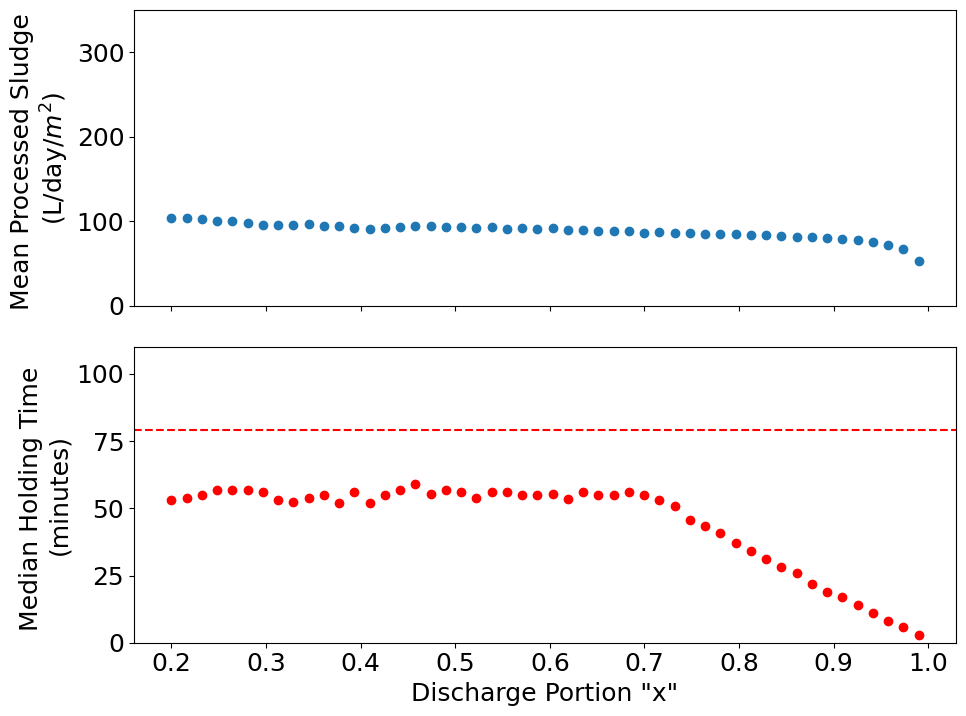

In [48]:
# Plotting processed volume under cold conditions and holding time under hot conditions

plt.rcParams.update({'font.size': 18})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7.5), sharex=True)

# First subplot: Scatter plot of Processed Vol vs Discharge factor x
ax1.scatter(x_values, Processed_Vol_x)
ax1.set_ylim(0, 350)  # Set y-axis limits
ax1.set_ylabel('Mean Processed Sludge \n(L/day/$m^2$)', fontsize=18)
#ax1.set_title('Effect on Processed Volume')

# Second subplot: Scatter plot of Holding Time vs Discharge factor x
ax2.scatter(x_values, Median_Holding_Time_x_2, color='red')
ax2.set_ylim(0, 110)  # Set y-axis limits
ax2.set_ylabel('Median Holding Time \n(minutes)', fontsize=18)
#ax2.set_title('Effect on Holding Time')
ax2.axhline(y=79, color='red', linestyle='--')  # Add horizontal line at y=79 (necessary holding time for 90% reduction at 72 °C)

# Set the x-axis label for the second subplot (shared x-axis)
ax2.set_xlabel('Discharge Portion "x"')

# Adjust the layout to prevent overlapping labels
plt.tight_layout()
#plt.savefig('/Users/tim-luan/Documents/Master Thesis/figures/Param_Discharge_portion')

In [29]:
# MAPPING MAIN TANK CAPACITY UNDER COLD CONDITIONS

start_date = '2021-07-01'
end_date = '2021-08-01'

start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
difference = end_date_dt - start_date_dt
days_difference = difference.days

df_sliced = df.loc[start_date:end_date]

MT_sim = pd.Series([0.0] * len(df_sliced['GHI1']), index=df_sliced.index, dtype='float64')

#Standard values with Main tank capacity analysis
U = 2.413793103448276
k = 0.993103448275862
T_flow = 78
e = 0.6
x = 0.5
Main_tank_cap_values = np.linspace(100, 360, 13) #Varying the Main tank capacity to see its effect

Processed_Vol_Main_tank_cap = []
Median_Holding_Time_Main_tank_cap = []

for Main_tank_cap in Main_tank_cap_values:
    T_flow_reached = 0
    Holding_time = [0]
    Median_Holding_Time = 0
    A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100)
    MT_sim.iloc[0] = df_sliced['airtemp'].iloc[0]
    for i in range(len(df_sliced['GHI1']) - 1):
        if MT_sim.iloc[i] > T_past:
            Holding_time[T_flow_reached] +=1
        if MT_sim.iloc[i] < T_flow:
            MT_sim.iloc[i + 1] = (MT_sim.iloc[i] +
                              k * df_sliced['GHI1'].iloc[i] * (0.1044*Main_tank_cap/10) * 60 / (4184 * Main_tank_cap) -
                              U * A * (MT_sim.iloc[i] - df_sliced['airtemp'].iloc[i]) * 60 / (4184 * Main_tank_cap))
        else:
            T_preheated= df_sliced['airtemp'].iloc[i] + e*(T_flow-df_sliced['airtemp'].iloc[i])
            MT_sim.iloc[i + 1] = x*T_flow + (1-x)*T_preheated
            T_flow_reached +=1
            Holding_time.append(0)
            
    Average_Processed_Vol = (T_flow_reached*(1-x)*Main_tank_cap)/days_difference/(0.1044*Main_tank_cap/10)
    Processed_Vol_Main_tank_cap.append(Average_Processed_Vol)
    Holding_time.pop()
    Median_Holding_time = np.median(Holding_time)
    Median_Holding_Time_Main_tank_cap.append(Median_Holding_time)


In [30]:
# MAPPING MAIN TANK CAPACITY UNDER HOT CONDITIONS

start_date = '2021-03-01'
end_date = '2021-04-01'

start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
difference = end_date_dt - start_date_dt
days_difference = difference.days

df_sliced = df.loc[start_date:end_date]

MT_sim = pd.Series([0.0] * len(df_sliced['GHI1']), index=df_sliced.index, dtype='float64')

#Standard values with Main tank capacity analysis
U = 2.413793103448276
k = 0.993103448275862
T_flow = 78 
e = 0.6 
x = 0.5 
Main_tank_cap_values = np.linspace(100, 360, 13) #Varying the Main tank capacity to see its effect

Processed_Vol_Main_tank_cap_2 = []
Median_Holding_Time_Main_tank_cap_2 = []

for Main_tank_cap in Main_tank_cap_values:
    T_flow_reached = 0
    Holding_time = [0]
    Median_Holding_Time = 0
    A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100)
    MT_sim.iloc[0] = df_sliced['airtemp'].iloc[0]
    for i in range(len(df_sliced['GHI1']) - 1):
        if MT_sim.iloc[i] > T_past:
            Holding_time[T_flow_reached] +=1
        if MT_sim.iloc[i] < T_flow:
            MT_sim.iloc[i + 1] = (MT_sim.iloc[i] +
                              k * df_sliced['GHI1'].iloc[i] * (0.1044*Main_tank_cap/10) * 60 / (4184 * Main_tank_cap) -
                              U * A * (MT_sim.iloc[i] - df_sliced['airtemp'].iloc[i]) * 60 / (4184 * Main_tank_cap))
        else:
            T_preheated= df_sliced['airtemp'].iloc[i] + e*(T_flow-df_sliced['airtemp'].iloc[i])
            MT_sim.iloc[i + 1] = x*T_flow + (1-x)*T_preheated
            T_flow_reached +=1
            Holding_time.append(0)
            
    Average_Processed_Vol = (T_flow_reached*(1-x)*Main_tank_cap)/days_difference/(0.1044*Main_tank_cap/10)
    Processed_Vol_Main_tank_cap_2.append(Average_Processed_Vol)
    Holding_time.pop()
    Median_Holding_time = np.median(Holding_time)
    Median_Holding_Time_Main_tank_cap_2.append(Median_Holding_time)


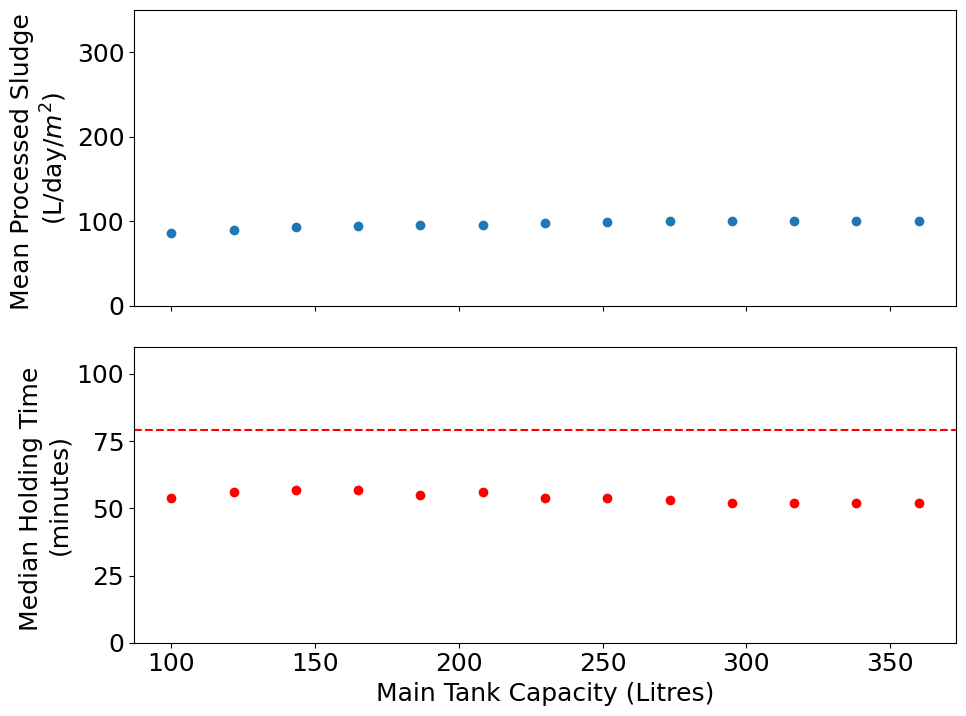

In [50]:
# Plotting processed volume under cold conditions and holding time under hot conditions

plt.rcParams.update({'font.size': 18})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7.5), sharex=True)

# First subplot: Scatter plot of Processed Vol vs Main tank cap
ax1.scatter(Main_tank_cap_values, Processed_Vol_Main_tank_cap)
ax1.set_ylim(0, 350)  # Set y-axis limits
ax1.set_ylabel('Mean Processed Sludge \n(L/day/$m^2$)', fontsize=18)
#ax1.set_title('Effect on Processed Volume')

# Second subplot: Scatter plot of Holding Time vs Main tank cap
ax2.scatter(Main_tank_cap_values, Median_Holding_Time_Main_tank_cap_2, color='red')
ax2.set_ylim(0, 110)  # Set y-axis limits
ax2.set_ylabel('Median Holding Time \n(minutes)', fontsize=18)
#ax2.set_title('Effect on Holding Time')
ax2.axhline(y=79, color='red', linestyle='--') # Add horizontal line at y=79 (necessary holding time for 90% reduction at 72 °C)

# Set the x-axis label for the second subplot (shared x-axis)
ax2.set_xlabel('Main Tank Capacity (Litres)')

# Adjust the layout to prevent overlapping labels
plt.tight_layout()
#plt.savefig('/Users/tim-luan/Documents/Master Thesis/figures/Param_MTC')